# Burgers Equation

$$\frac{\partial u}{\partial t} + u \frac{\partial u}{\partial x} = \nu \frac{\partial^2 u}{\partial x^2}, x\in[-1,1], t\in [0,1]$$
$$u(-1,t)=u(1,t)=0, u(x,0)=-\sin (\pi x)$$

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


Compiling model...
'compile' took 0.820880 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [2.31e-03, 3.40e-02, 3.82e-01]    [2.31e-03, 3.40e-02, 3.82e-01]    []  
1000      [3.90e-02, 5.16e-04, 5.44e-02]    [3.90e-02, 5.16e-04, 5.44e-02]    []  
2000      [2.98e-02, 6.29e-05, 4.63e-02]    [2.98e-02, 6.29e-05, 4.63e-02]    []  
3000      [2.34e-02, 9.14e-05, 3.45e-02]    [2.34e-02, 9.14e-05, 3.45e-02]    []  
4000      [6.03e-03, 5.48e-05, 4.26e-03]    [6.03e-03, 5.48e-05, 4.26e-03]    []  
5000      [3.39e-03, 3.53e-05, 2.59e-03]    [3.39e-03, 3.53e-05, 2.59e-03]    []  
6000      [2.52e-03, 3.34e-05, 1.84e-03]    [2.52e-03, 3.34e-05, 1.84e-03]    []  
7000      [1.85e-03, 2.91e-05, 1.22e-03]    [1.85e-03, 2.91e-05, 1.22e-03]    []  
8000      [1.79e-03, 2.21e-05, 8.82e-04]    [1.79e-03, 2.21e-05, 8.82e-04]    []  
9000      [1.36e-03, 1.78e-05, 7.43e-04]    [1.36e-03, 1.78e-05, 7.43e-04]    []  
10000     [1.66

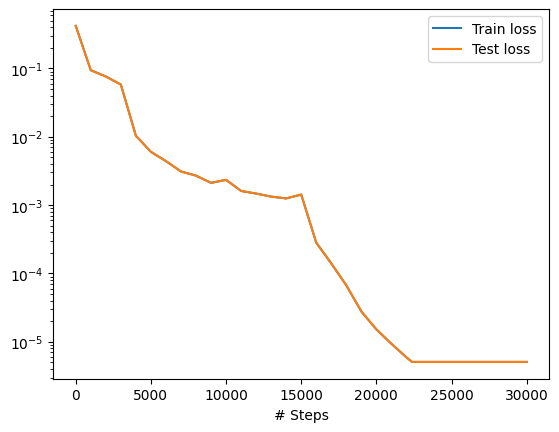

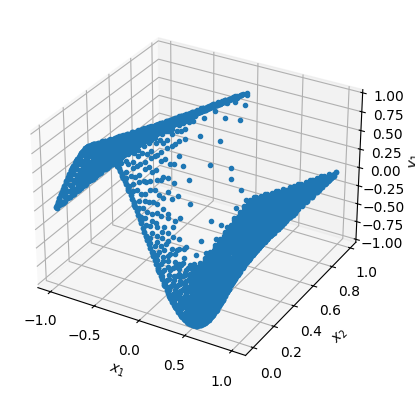

In [1]:
import deepxde as dde
import numpy as np

def pde(x, y):
    dy_x = dde.grad.jacobian(y, x, i=0, j=0)
    dy_t = dde.grad.jacobian(y, x, i=0, j=1)
    dy_xx = dde.grad.hessian(y, x, i=0, j=0)
    return dy_t + y * dy_x - 0.01 / np.pi * dy_xx


geom = dde.geometry.Interval(-1, 1)
timedomain = dde.geometry.TimeDomain(0, 0.99)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.icbc.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.icbc.IC(
    geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial
)

data = dde.data.TimePDE(
    geomtime, pde, [bc, ic], num_domain=2540, num_boundary=80, num_initial=160
)
net = dde.nn.FNN([2] + [20] * 3 + [1], "tanh", "Glorot normal")
model = dde.Model(data, net)

model.compile("adam", lr=1e-3)
model.train(iterations=15000)
model.compile("L-BFGS")
losshistory, train_state = model.train()
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from deep_macrofin import PDEModel
from deep_macrofin import ActivationType, OptimizerType, Comparator, set_seeds

set_seeds(0)
pde = PDEModel("burgers", config={"num_epochs": 15000, "optimizer_type": OptimizerType.Adam})
pde.set_state(["x", "t"], {"x": [-1., 1.], "t": [0., 1.]})
pde.add_endog("u", config={"hidden_units": [20, 20, 20]})
pde.add_endog_equation(r"$\frac{\partial u}{\partial t} + u * \frac{\partial u}{\partial x} = 0.01 / pi * \frac{\partial^2 u}{\partial x^2}$", label="base_ode")

t_m1 = torch.ones((100, 2))
t_m1[:, 0] *= -1
t_m1[:, 1] = torch.Tensor(np.linspace(0, 1, 100))
t_p1 = torch.ones((100, 2))
t_p1[:, 1] = torch.Tensor(np.linspace(0, 1, 100))

zero_t = torch.zeros((100, 2))
zero_t[:, 0] = torch.Tensor(np.linspace(-1, 1, 100))
zero_t_u = - torch.sin(torch.pi * zero_t[:, 0:1])

pde.add_endog_condition("u", 
                        "u(SV)", {"SV": t_m1},
                        Comparator.EQ,
                        "0", {},
                        label="bc1")
pde.add_endog_condition("u", 
                        "u(SV)", {"SV": t_p1},
                        Comparator.EQ,
                        "0", {},
                        label="bc2")
pde.add_endog_condition("u", 
                        "u(SV)", {"SV": zero_t},
                        Comparator.EQ,
                        "zero_t_u", {"zero_t_u": zero_t_u},
                        label="ic")

print(pde)
if not os.path.exists("./models/burgers/model.pt"):
    pde.train_model("./models/burgers", "model.pt", True)
    # pde.set_config({"num_epochs": 1000, "optimizer_type": OptimizerType.LBFGS})
    # pde.train_model("./models/burgers", "model_lbfgs.pt", True)
    pde.eval_model(True)
else:
    pde.load_model(torch.load("./models/burgers/model.pt"))
    pde.eval_model(True)

============================Summary of Model burgers============================
Config: {
 "batch_size": 100,
 "num_epochs": 15000,
 "lr": 0.001,
 "loss_log_interval": 100,
 "optimizer_type": "Adam"
}
Latex Variable Mapping:
{}
User Defined Parameters:
{}

================================State Variables=================================
x: [-1.0, 1.0]
t: [0.0, 1.0]

=====================================Agents=====================================

================================Agent Conditions================================

==============================Endogenous Variables==============================
Endogenous Variable Name: u
EndogVar(
  (model): Sequential(
    (linear_0): Linear(in_features=2, out_features=20, bias=True)
    (activation_0): Tanh()
    (linear_1): Linear(in_features=20, out_features=20, bias=True)
    (activation_1): Tanh()
    (linear_2): Linear(in_features=20, out_features=20, bias=True)
    (activation_2): Tanh()
    (final_layer): Linear(in_features=20, ou

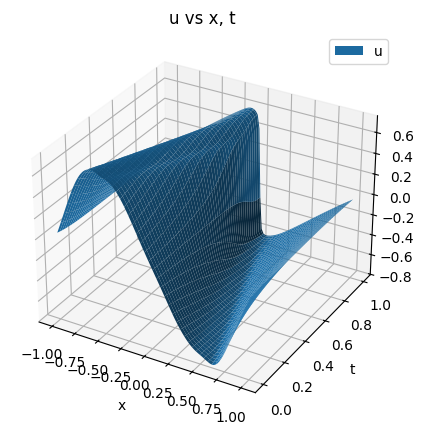

In [2]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5), subplot_kw={"projection": "3d"})
pde.endog_vars["u"].plot("u", {"x": [-1, 1.], "t": [0, 1.]}, ax=ax)
plt.subplots_adjust()
plt.show()

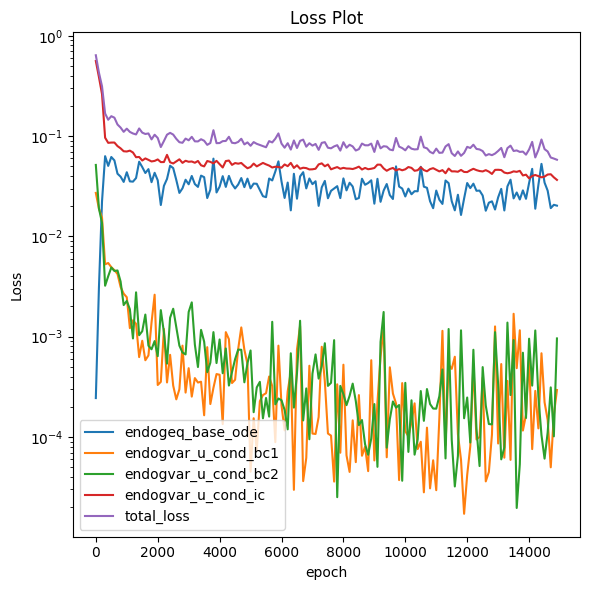

In [3]:
from deep_macrofin import plot_loss_df
plot_loss_df(fn="./models/burgers/model_loss.csv", loss_plot_fn="./models/burgers/model_loss.png")